In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
plt.rc('font', size=18)
import os

# Explore and Cut Data

In [ ]:
full_nyt_corpus = pd.read_csv('../nyt_corpus/unprocessed_full_data_df.csv')

## get word counts
t_wc = {}
for idx, body in tqdm(full_nyt_corpus['body'].iteritems(), total=len(full_nyt_corpus)):
    if pd.notnull(body):
        t_wc[idx] = len(body.strip().split())
    else:
        t_wc[idx] = 0

full_nyt_corpus['wc'] = pd.Series(t_wc)
full_nyt_corpus['wc_bins'] = pd.cut(full_nyt_corpus['wc'], bins=range(0, 2000, 100))
full_nyt_corpus['pub_date'] = pd.to_datetime(full_nyt_corpus['pub_date'])
full_nyt_corpus['date_bins'] = pd.cut(full_nyt_corpus['pub_date'], bins=20)

## filter to crime stories
crime_stories = (full_nyt_corpus
                 .loc[lambda df: df['body'].notnull()]
                 .loc[lambda df: df['body'].str.lower().str.contains('crime')]
                )

crime_stories.to_csv('../data/nyt-corpus-crime-stores.csv')

In [ ]:
## Plot: Counts of Articles
ax = full_nyt_corpus['date_bins'].value_counts().sort_index().plot(label='# All Stories', figsize=(4, 4))
ax = crime_stories['date_bins'].value_counts().sort_index().plot(label='# Crime Stories', ax=ax)
plt.semilogy()
plt.legend()
plt.ylabel('Counts')
date_strs = list(map(lambda x: x.left.strftime('%Y-%m'), crime_stories['date_bins'].value_counts().sort_index().index))
plt.xticks(range(0, 20, 2), date_strs[::2], rotation='vertical')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
## Plot: Word Count
ax = (full_nyt_corpus['wc_bins']
      .value_counts()
      .sort_index()
      .pipe(lambda s: s/s.sum())
      .plot(kind='bar', figsize=(4, 4), alpha=.5, label='All Stories')
     )
(crime_stories['wc_bins']
 .value_counts()
 .sort_index()
 .pipe(lambda s: s/s.sum()).plot(kind='bar', ax=ax, label='Crime Stories', alpha=.5, color='olive')
)
plt.legend()
plt.xticks(range(0, 20, 2), range(0, 2000, 200), rotation='vertical')
plt.ylabel('Frac. stories')
plt.xlabel('Word Count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Model Paragraphs

In [2]:
import numpy as np 
import pandas as pd

In [3]:
crime_data = pd.read_csv('../data/nyt-corpus-crime-stores.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
glove = open('../data/glove.6B.50d.txt', encoding='utf-8').readlines()
glove = list(map(lambda x: x.strip(), glove))

In [5]:
glove_dict = {}
for line in glove:
    chunks = line.split()
    word = chunks[0]
    vec = list(map(float, chunks[1:]))
    glove_dict[word] = np.array(vec)

In [7]:
from more_itertools import unique_everseen
import unidecode
# import spacy
import string
from nltk.corpus import stopwords
import re

In [8]:
english_stopwords = stopwords.words('english')
page_num_regex = re.compile('\s[a-f]\d+(\s|$)')
specific_stop_words = [
    'article',
    'page',
    'sportsmonday',
    'sportstuesday',
    'sportswednesday',
    'sportsthursday',
    'sportsfriday',
    'sportssaturday',
    'sportssunday',
    'times',
    'caption',
    'science times',
    'business day',
    'editing error page',
    'ap sports',
    'ap',
    'reuters',
    'op ed contributor',
    'books times',
    'music review',
    'op ed',
    'sports times',
    'articles , pages',
    'articles pages',
    'special today',
    'science f1',
    'art review',
    'television review',
    'articles series',
    'ed contributor',
    'news briefs',
    'articles series',
    'news analysis',
    'sports people',
    'company news',
    'metro : new york',
    'metro : new jersey',
    'metro : new york city',
    'metro : new york state',
    'lead : editor',
    'op - ed',
    'company reports',
    'dance review',
    'theater review',
    'public lives',
    'world business , section w',
    'world business briefing : europe',
    'world business briefing : asia',
    'world business briefings : middle east',
    'world business briefing : africa',
    'world business briefing : americas',
    'world business briefings : europe',
    'world business briefings : asia',
    'world business briefing : world trade'
]
stopwords = specific_stop_words + english_stopwords

In [9]:
def preprocess_lite(body):
    """preprocess without spacy."""
    body = body.strip()
    
    ### replace stopwords
    for stopword in stopwords:
        ## stopword in body
        body = body.replace(' ' + stopword + ' ', ' ')
        ## stopword at start
        if body[:len(stopword + ' ')] == (stopword + ' '):
            body = body[len(stopword + ' '):]
        ## stopword at end
        if body[-len(' ' + stopword):] == (' ' + stopword):
            body = body[:-len(' ' + stopword)]
        
        
    ### replace page numbers
    body = re.sub(page_num_regex, ' ', body)
        
    return unidecode.unidecode(body)

In [11]:
def process_paragraphs(text):
    text = unidecode.unidecode(text)
    
    ## remove duplicate paragraphs
    paragraphs = text.split('\n')
    paragraphs = list(filter(lambda x: x != '', paragraphs))
    paragraphs = list(unique_everseen(paragraphs))[:10]
    
    ## 
    mean_paragraph_vecs = []
    for paragraph in paragraphs:
        paragraph = paragraph.lower()
        
        # remove punc
        for punct in '!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~':
            paragraph = paragraph.replace(punct, ' ')

        # remove stopwords
        paragraph = preprocess_lite(paragraph)
        
        paragraph_vecs = []
        for word in paragraph.split():
            if word in glove_dict:
                paragraph_vecs.append(glove_dict[word])
        
        par_mean = np.array(paragraph_vecs).mean(axis=0)
        mean_paragraph_vecs.append(par_mean)
    return paragraphs, mean_paragraph_vecs

In [12]:
import swifter

In [13]:
par_vecs = crime_data['body'].iloc[:10000].swifter.apply(process_paragraphs)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.


In [8]:
import json

In [13]:
tm_docs = []
       
with open('../topic_model/data/vocab.txt') as f:
    vocab = f.read().split('\n')[:-1]
    
with open('../topic_model/data/doc_vecs.json') as f:
    for line in f:
        tm_docs.append(json.loads(line))

In [25]:
def process_tm_vec(vecs):
    mean_paragraph_vecs = []
    for vec in vecs:
        paragraph_vecs = []
        for word_id in vec:
            word = vocab[word_id]
            if word in glove_dict:
                paragraph_vecs.append(glove_dict[word])

        par_mean = np.array(paragraph_vecs).mean(axis=0)
        mean_paragraph_vecs.append(par_mean)
    return mean_paragraph_vecs

In [27]:
all_vecs = []
for vecs in tqdm(tm_docs):
    mean_vecs = process_tm_vec(vecs['paragraphs'])
    all_vecs.extend(mean_vecs)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [28]:
len(all_vecs)

1031448

In [57]:
all_vecs_arr_pre_drop = np.zeros((len(all_vecs), len(all_vecs[0])))
for idx, vec in enumerate(all_vecs):
    all_vecs_arr_pre_drop[idx] = vec

all_vecs_arr = all_vecs_arr_pre_drop[np.where(~np.isnan(all_vecs_arr_pre_drop).any(axis=1))]

In [71]:
accepted = np.where(~np.isnan(all_vecs_arr_pre_drop).any(axis=1))[0]
accepted_set = set(np.where(~np.isnan(all_vecs_arr_pre_drop).any(axis=1))[0])

In [32]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=10).fit(all_vecs_arr[:200000])

In [50]:
par_clusters = kmeans.predict(all_vecs_arr)

In [70]:
par_clusters.shape

(998374,)

In [76]:
idx_to_accepted = {v:k for k,v in enumerate(accepted)}

In [82]:
nested_par_clusters = []
idx = 0
for doc in tqdm(tm_docs):
    doc_pars= []
    for par in doc['paragraphs']:
        if idx in accepted_set:
            doc_pars.append(int(par_clusters[idx_to_accepted[idx]]))
        idx += 1
    nested_par_clusters.append(doc_pars)

In [84]:
json.dump(nested_par_clusters, open('results/Kmeans_nested_par_clusters.json', 'w'))

In [219]:
%matplotlib inline
import matplotlib.pyplot as plt

In [220]:
plt.rc('font', size=18)

Text(0.5, 0, '# Paragraphs')

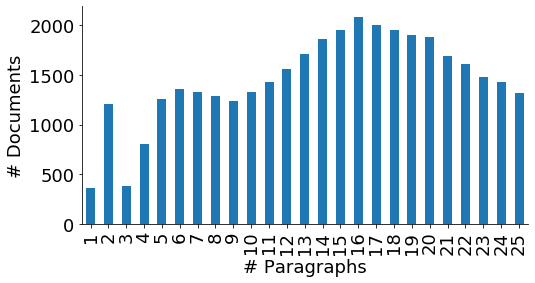

In [227]:
ax = par_vecs.str.get(1).str.len().value_counts().sort_index().iloc[:25].plot(kind='bar', figsize=(8, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('# Documents')
plt.xlabel('# Paragraphs')

In [228]:
all_vecs_arr = np.zeros((len(all_vecs), len(all_vecs[0])))
for idx, vec in enumerate(all_vecs):
    all_vecs_arr[idx] = vec

all_vecs_arr = all_vecs_arr[np.where(~np.isnan(all_vecs_arr).any(axis=1))]

In [236]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=5).fit(all_vecs_arr[:200000])

Text(0.5, 0, 'Cluster Idx')

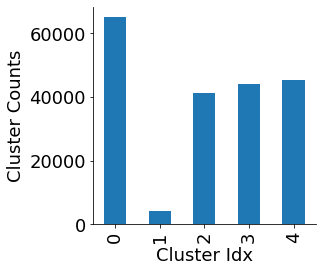

In [237]:
ax = pd.Series(kmeans.labels_).value_counts().sort_index().plot(kind='bar', figsize=(4, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel('Cluster Counts')
plt.xlabel('Cluster Idx')

In [239]:
kmeans.predict(par_vecs.iloc[0][1])

array([0, 0, 0, 0, 4, 0])

In [161]:
from tqdm import tqdm_notebook as tqdm

In [240]:
par_clusters = []
for par in tqdm( par_vecs):
    t_par = np.zeros((len(par[1]), 50))
    for idx, x in enumerate(par[1]):
        t_par[idx] = x
    t_par = t_par[np.where(~np.isnan(t_par).any(axis=1))]
    c = kmeans.predict(t_par)
    par_clusters.append(c)

In [241]:
transition_mat = np.zeros((5, 5))

In [242]:
for c in par_clusters:
    for c_0, c_1 in list(zip(c[:-1], c[1:])):
        transition_mat[c_0, c_1] += 1

In [243]:
import seaborn as sns

Text(0.5, 1, 'Transition Probability')

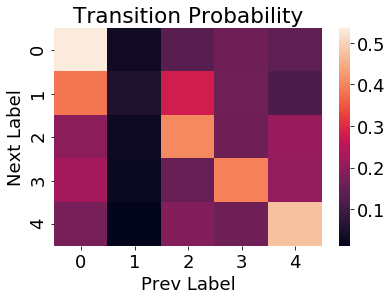

In [244]:
sns.heatmap((transition_mat.T / transition_mat.sum(axis=1)).T)
plt.xlabel('Prev Label')
plt.ylabel('Next Label')
plt.title('Transition Probability')

In [ ]:
par_clusters = []
for par in tqdm( par_vecs):
    t_par = np.zeros((len(par[1]), 50))
    for idx, x in enumerate(par[1]):
        t_par[idx] = x
    t_par = t_par[np.where(~np.isnan(t_par).any(axis=1))]
    c = kmeans.predict(t_par)
    par_clusters.append(c)